In [2]:
import re

import nltk
import pandas as pd
import seaborn as sns

nltk.download('punkt')
import string

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn import model_selection, svm
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             confusion_matrix, f1_score,
                             precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.model_selection import GridSearchCV, train_test_split

nltk.download('stopwords')
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              RandomForestClassifier)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB

plt.style.use('fivethirtyeight')
plt.style.use('dark_background')


[nltk_data] Downloading package punkt to /home/anonymous/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anonymous/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df =pd.read_csv(r'./Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Unique values of sentiment
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

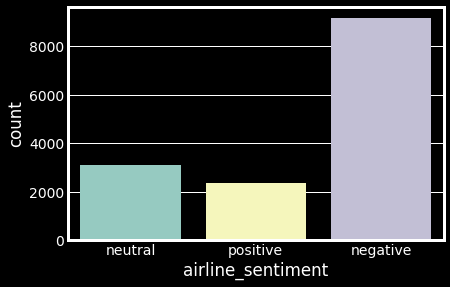

In [5]:
# Unique values of sentiment plot

ax = sns.countplot(x="airline_sentiment", data=df)

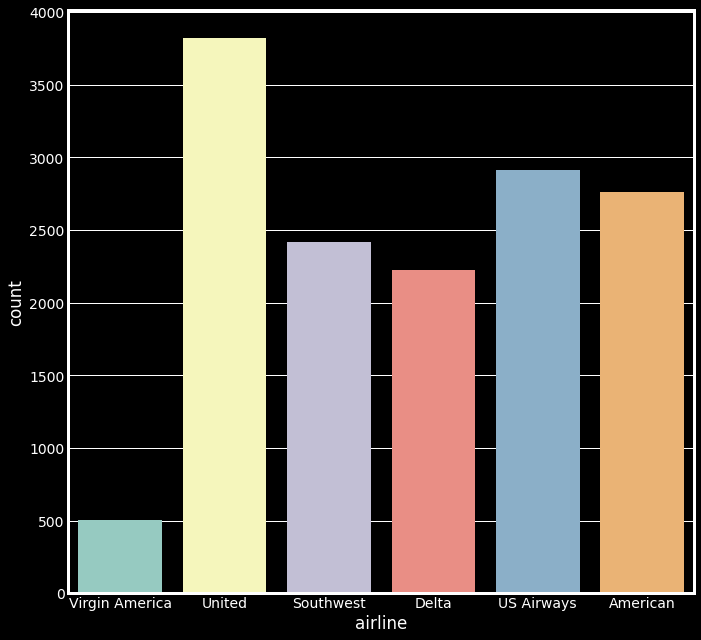

In [6]:
# Unique values of airline

plt.figure(figsize=(10,10))
ax = sns.countplot(x="airline", data=df)

In [7]:
# I am tokenizing the tweet and also taking tokens from second index onwards as initital to gives airline name and '@' and lowering thm and later making it back a sentence
def clean_the_tweet(text):
  tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
  tokens = [token.lower() for token in tokens]
  return ' '.join(tokens[2:])

                 

def text_process(msg):
  nopunc =[char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

def check_scores(clf,X_train, X_test, y_train, y_test):

  model=clf.fit(X_train, y_train)
  predicted_class=model.predict(X_test)
  predicted_class_train=model.predict(X_train)
  test_probs = model.predict_proba(X_test)
  test_probs = test_probs[:, 1]
  yhat = model.predict(X_test)
  lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_probs)
  lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
  
  print('Train confusion matrix is: ',)
  print(confusion_matrix(y_train, predicted_class_train))

  print()
  print('Test confusion matrix is: ')
  print(confusion_matrix(y_test, predicted_class))
  print()
  print(classification_report(y_test,predicted_class)) 
  print() 
  train_accuracy = accuracy_score(y_train,predicted_class_train)
  test_accuracy = accuracy_score(y_test,predicted_class)


  print("Train accuracy score: ", train_accuracy)
  print("Test accuracy score: ",test_accuracy )
  print()
  train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
  test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

  print("Train ROC-AUC score: ", train_auc)
  print("Test ROC-AUC score: ", test_auc)
  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(lr_recall, lr_precision)
  ax1.set(xlabel="Recall", ylabel="Precision")

  plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
    
  print()
  print('Are under Precision-Recall curve:', lr_f1)
  
  fpr, tpr, _ = roc_curve(y_test, test_probs)


  ax2.plot(fpr, tpr)
  ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

  print("Area under ROC-AUC:", lr_auc)
  return train_accuracy, test_accuracy, train_auc, test_auc

def grid_search(model, parameters, X_train, Y_train):
  #Doing a grid
  grid = GridSearchCV(estimator=model,
                       param_grid = parameters,
                       cv = 2, verbose=2, scoring='roc_auc')
  #Fitting the grid 
  grid.fit(X_train,Y_train)
  print()
  print()
  # Best model found using grid search
  optimal_model = grid.best_estimator_
  print('Best parameters are: ')
  print( grid.best_params_)

  return optimal_model

In [8]:
# removing neutral tweets

# df = df[df['airline_sentiment']!='neutral']
df['cleaned_tweet'] = df['text'].apply(clean_the_tweet)

df.head()
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: 1 if x =='positive' else -1 if x == 'negative' else 0)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
0,570306133677760513,0,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),dhepburn said
1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),you ve added commercials to the experience tacky
2,570301083672813571,0,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),didn t today must mean i need to take another ...
3,570301031407624196,-1,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),s really aggressive to blast obnoxious enterta...
4,570300817074462722,-1,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),it s a really big bad thing about it


In [9]:
# Cleaning the tweets, removing punctuation marks
df['cleaned_tweet'] = df['cleaned_tweet'].apply(text_process)
df.reset_index(drop=True, inplace = True)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
0,570306133677760513,0,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),dhepburn said
1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),added commercials experience tacky
2,570301083672813571,0,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),today must mean need take another trip
3,570301031407624196,-1,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious entertainmen...
4,570300817074462722,-1,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),really big bad thing


In [10]:
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(df.cleaned_tweet)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df['airline_sentiment'], random_state=42)

In [11]:
SVM = svm.SVC( probability=True)
s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc = check_scores(SVM,x_train, x_test, y_train, y_test)

ValueError: multiclass format is not supported

In [12]:
# Tuning the hyperparameters
parameters ={
    "C":[0.1,1,10],
    "kernel":['linear', 'rbf', 'sigmoid'],
    "gamma":['scale', 'auto']
}



svm_optimal = grid_search(svm.SVC(probability=True), parameters,x_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  26.9s


/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  26.5s


/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  38.4s


/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  34.6s


/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=  26.2s


/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=  31.2s


/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  24.3s


/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  27.5s


/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  22.7s


/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  22.7s


/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV] END ..................C=0.1, gamma=auto, kernel=sigmoid; total time=  20.2s


/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV] END ..................C=0.1, gamma=auto, kernel=sigmoid; total time=  18.4s


/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV] END ....................C=1, gamma=scale, kernel=linear; total time=  24.1s


/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV] END ....................C=1, gamma=scale, kernel=linear; total time=  25.5s


/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/classes/AI-lab/sentimental-analysis/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=  43.9s


In [ ]:
so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc = check_scores(svm_optimal,x_train, x_test, y_train, y_test)

In [ ]:
m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc = check_scores(MultinomialNB(),x_train, x_test, y_train, y_test)

In [ ]:
g_train_accuracy, g_test_accuracy, g_train_auc, g_test_auc=check_scores(GaussianNB(),x_train.toarray(), x_test.toarray(), y_train, y_test)

In [ ]:
a_train_accuracy, a_test_accuracy, a_train_auc, a_test_auc=check_scores(AdaBoostClassifier(),x_train,x_test, y_train, y_test)

In [ ]:
params = {'n_estimators': [10, 50, 100, 500],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
 'algorithm': ['SAMME', 'SAMME.R']}

ada_optimal_model = grid_search(AdaBoostClassifier(), params,x_train, y_train)

In [ ]:
ao_train_accuracy, ao_test_accuracy, ao_train_auc, ao_test_auc=check_scores(ada_optimal_model,x_train,x_test, y_train, y_test)

In [ ]:
kfold = model_selection.KFold(n_splits = 3)
  
# bagging classifier
model = BaggingClassifier(base_estimator = MultinomialNB(),
                          n_estimators = 100)

b_train_accuracy, b_test_accuracy, b_train_auc, b_test_auc= check_scores(model,x_train,x_test, y_train, y_test)

In [ ]:
r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc= check_scores(RandomForestClassifier(random_state=0).fit(x_train, y_train), x_train,x_test,y_train,y_test)

In [ ]:
data = [('Random Forest', r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc),
 ('MultinomialNB',m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc  ),
('Bagged MultinomialNB',b_train_accuracy, b_test_accuracy, b_train_auc, b_test_auc ),
 ('AdaBoost',a_train_accuracy, a_test_accuracy, a_train_auc, a_test_auc ),
('AdaBoost Optimized',ao_train_accuracy, ao_test_accuracy, ao_train_auc, ao_test_auc),
('Gaussian Naive Bayes',g_train_accuracy, g_test_accuracy, g_train_auc, g_test_auc),
('SVM', s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc),
('SVM Optimized', so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc)]


Scores_ =pd.DataFrame(data = data, columns=['Model Name','Train Accuracy', 'Test Accuracy', 'Train ROC', 'Test ROC'])
Scores_.set_index('Model Name', inplace = True)

Scores_


In [ ]:
model = svm.SVC(C=10, gamma='scale', kernel='rbf')
model.fit(x_train, y_train)

In [ ]:
sentence = '''@shashankroxx97 @GuruPrasadKP3 @nimmaupendra Yes ur father's KGF movie done with Ur grandfather's Technicians ( Stunt master's and other Technical teams are from TAMILNADU ) Oombu poi'''

In [ ]:
df.airline_sentiment.unique()

In [ ]:
model.predict(vectorizer.fit_transform(df.cleaned_tweet))